In [1]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

rawdf = pd.read_csv
df = pd.read_csv('rd4dd_census_clean.csv')

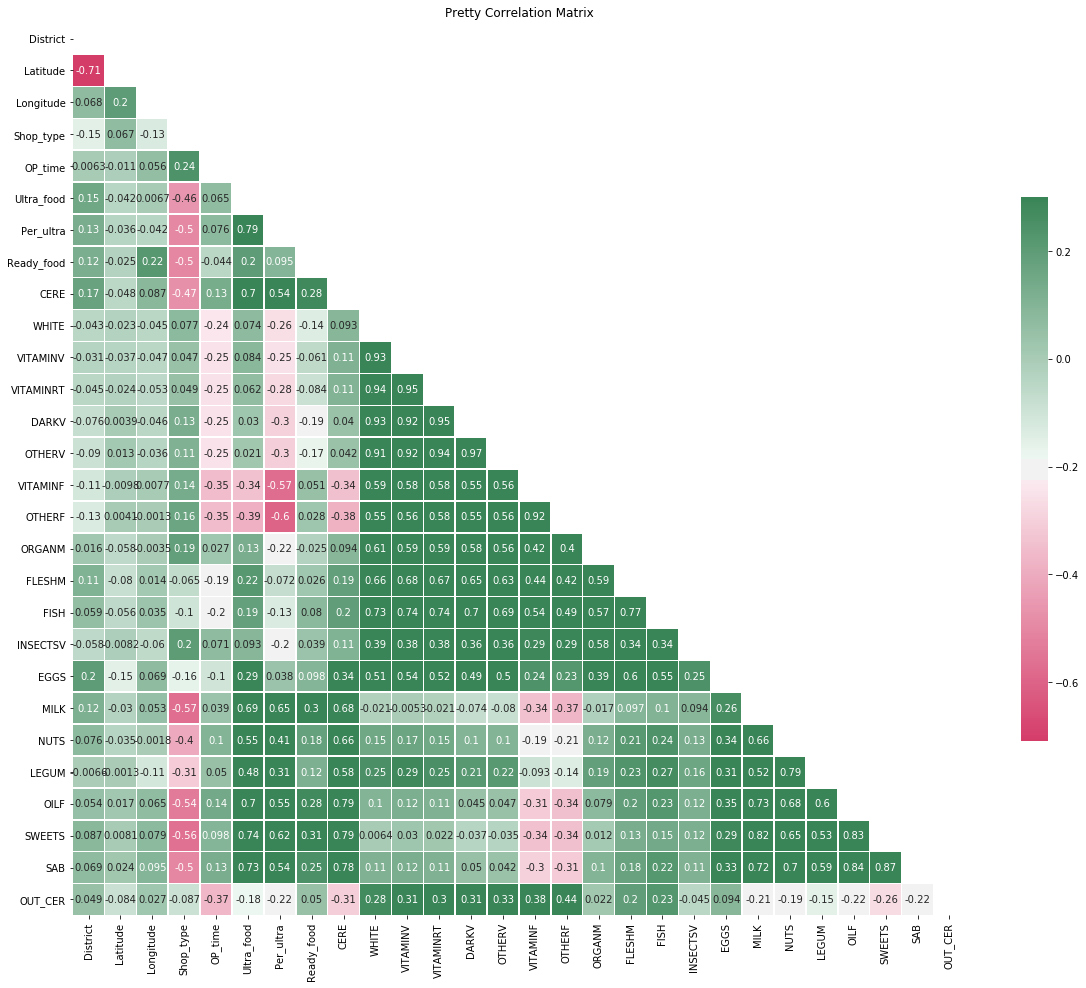

In [20]:
#pretty correlation matrix

coordf = df.copy().corr()
#mask = (coordf>0.5) or (coordf<0.5)
#print(coordf[(coordf>0.5) | (coordf<-0.5)])

mask = np.triu(np.ones_like(coordf, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(0, 500, as_cmap=True)
sns.heatmap(coordf, annot=True, mask=mask, cmap=cmap, vmax=.3, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Pretty Correlation Matrix')
plt.show()

In [19]:
mlpdf=df.copy()
#mlpdf['OP_time'] = mlpdf.apply(lambda x: 2 if int(x['OP_time']) <= 2 else 4, axis=1) 
#see note at end of results summary

y = mlpdf['OP_time'].values
X = mlpdf.drop(['OP_time'], axis = 1)

print(X.columns)

X['District'] = pd.get_dummies(X['District'])

#shop_type_dummy = pd.get_dummies(X.Shop_type, prefix = 'Shop_type')

#X = X.drop(['Shop_type'], axis = 1)
#X = pd.merge(X, shop_type_dummy, left_index = True, right_index = True)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=50)

X_train.to_csv("X_train2.csv")
X_test.to_csv("X_test2.csv")
y_train.to_csv("y_train2.csv")
y_test.to_csv("y_test2.csv")


#scale = StandardScaler()
#X_train = pd.DataFrame(scale.fit_transform(X_train))
#X_test = pd.DataFrame(scale.transform(X_test))
X_train.columns=X.columns #need to retain column names for later
X_test.columns=X.columns

Index(['District', 'Latitude', 'Longitude', 'Shop_type', 'Ultra_food',
       'Per_ultra', 'Ready_food', 'CERE', 'WHITE', 'VITAMINV', 'VITAMINRT',
       'DARKV', 'OTHERV', 'VITAMINF', 'OTHERF', 'ORGANM', 'FLESHM', 'FISH',
       'INSECTSV', 'EGGS', 'MILK', 'NUTS', 'LEGUM', 'OILF', 'SWEETS', 'SAB',
       'OUT_CER'],
      dtype='object')
   District   Latitude   Longitude  Shop_type  Ultra_food  Per_ultra  \
0         0  21.026078  105.839874          5           0          0   
1         0  21.010939  105.825442          5           0          0   
2         1  21.034148  105.817214          5           0          0   
3         0  21.017329  105.813375          5           0          0   
4         0  21.012653  105.812286          5           0          0   

   Ready_food  CERE  WHITE  VITAMINV  ...  FISH  INSECTSV  EGGS  MILK  NUTS  \
0           1     0      0         0  ...     0         0     0     0     0   
1           1     0      0         0  ...     0         0     0     

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

# Testing Models

### MLP Regression Using Top Five Positive Correlations

In [4]:
X_train1 = X_train[['Shop_type', 'OILF', 'CERE', 'SAB', 'NUTS']]
X_test1 = X_test[['Shop_type', 'OILF', 'CERE', 'SAB', 'NUTS']]
MLPRTop5p = MLPRegressor(max_iter = 1000,random_state=1).fit(X_train1, y_train)
MLPRTop5p_pred = MLPRTop5p.predict(X_test1)
MLPRTop5p_r2_score=r2_score(y_test, MLPRTop5p_pred)

print('R^2 score against test: %.4f'% MLPRTop5p_r2_score)
coordf2=coordf.rename(columns={"OP_time":"Correlation with OP_Time"})
coordf2['Correlation with OP_Time'].sort_values(ascending=False)[1:6].to_frame()

R^2 score against test: 0.3843


,Correlation with OP_Time
Shop_type,0.243522
OILF,0.144419
CERE,0.133925
SAB,0.129101
NUTS,0.102866


### MLP Regression Using Top Five Negative Correlations

In [5]:
X_train2 = X_train[['OTHERF', 'VITAMINF', 'VITAMINRT', 'VITAMINV', 'OTHERV']]
X_test2 = X_test[['OTHERF', 'VITAMINF', 'VITAMINRT', 'VITAMINV', 'OTHERV']]
MLPRTop5n = MLPRegressor(max_iter = 1000,random_state=1).fit(X_train2, y_train)
MLPRTop5n_pred = MLPRTop5n.predict(X_test2)
MLPRTop5n_r2_score=r2_score(y_test, MLPRTop5n_pred)

print('R^2 score against test: %.4f'% MLPRTop5n_r2_score)
coordf2=coordf.rename(columns={"OP_time":"Correlation with OP_Time"})
coordf2['Correlation with OP_Time'].sort_values()[1:6].to_frame()

R^2 score against test: 0.1488


,Correlation with OP_Time
OTHERF,-0.353150
VITAMINF,-0.350997
VITAMINRT,-0.254453
VITAMINV,-0.249269
OTHERV,-0.249029


### MLP Regression Using Five Features from RFE

In [6]:
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()
#pd.DataFrame(selection, columns=['Features']).style.hide_ind

X_train3 = X_train[selection]
X_test3 = X_test[selection]
MLPR5 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train3, y_train)
MLPR5_pred = MLPR5.predict(X_test3)
MLPR5_r2_score = r2_score(y_test, MLPR5_pred)

print('R^2 score against test: %.4f'% MLPR5_r2_score)
print('Features used:',' '.join(selection))

R^2 score against test: 0.1904
Features used: OTHERF ORGANM INSECTSV MILK OILF


In [5]:
!pip install mord

from mord import LogisticAT

estimator = LogisticAT(alpha=0)
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()
#pd.DataFrame(selection, columns=['Features']).style.hide_ind

X_train3 = X_train[selection]
X_test3 = X_test[selection]
MLPR5 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train3, y_train)
MLPR5_pred = MLPR5.predict(X_test3)
MLPR5_r2_score = r2_score(y_test, MLPR5_pred)

print('R^2 score against test: %.4f'% MLPR5_r2_score)
print('Features used:',' '.join(selection))

  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6013 sha256=a1545169bace99ca032657ec8bfb6312ba23c5499af48595dc7452333974e2c2
  Stored in directory: c:\users\jocel\appdata\local\pip\cache\wheels\80\1d\8a\bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord
R^2 score against test: 0.2156
Features used: Latitude Ready_food DARKV OTHERF ORGANM


### MLP Regression Using Ten Features from RFE


In [7]:
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train4 = X_train[selection]
X_test4 = X_test[selection]
MLPR10 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train4, y_train)
MLPR10_pred = MLPR10.predict(X_test4)
MLPR10_r2_score = r2_score(y_test, MLPR10_pred)

print('R^2 score against test: %.4f'% MLPR10_r2_score)
print('Features used:',' '.join(selection))

R^2 score against test: 0.3859
Features used: Shop_type Ready_food DARKV OTHERF ORGANM INSECTSV MILK NUTS OILF SAB


In [9]:
estimator = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train4 = X_train[selection]
X_test4 = X_test[selection]
MLPR10 = MLPRegressor(max_iter = 100000,random_state=1).fit(X_train4, y_train)
MLPR10_pred = MLPR10.predict(X_test4)
MLPR10_r2_score = r2_score(y_test, MLPR10_pred)

print('R^2 score against test: %.4f'% MLPR10_r2_score)
print('Features used:',' '.join(selection))

C:\Users\jocel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jocel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

R^2 score against test: 0.4049
Features used: Shop_type Ready_food CERE DARKV OTHERF ORGANM MILK NUTS LEGUM OILF


In [10]:
estimator = LogisticAT()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train4 = X_train[selection]
X_test4 = X_test[selection]
MLPR10 = MLPRegressor(max_iter = 100000,random_state=1).fit(X_train4, y_train)
MLPR10_pred = MLPR10.predict(X_test4)
MLPR10_r2_score = r2_score(y_test, MLPR10_pred)

print('R^2 score against test: %.4f'% MLPR10_r2_score)
print('Features used:',' '.join(selection))

R^2 score against test: 0.2853
Features used: Shop_type Ultra_food Ready_food DARKV VITAMINF OTHERF ORGANM OILF SAB OUT_CER


### MLP Regression Using Fifteen Features from RFE

In [65]:
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train5 = X_train[selection]
X_test5 = X_test[selection]
MLPR15 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train5, y_train)
MLPR15_pred = MLPR15.predict(X_test5)
MLPR15_r2_score = r2_score(y_test, MLPR15_pred)

print('R^2 score against test: %.4f'% MLPR15_r2_score)
print('Features used:',' '.join(selection))

print(MLPR15_pred)

R^2 score against test: 0.4565
Features used: District Shop_type Ready_food CERE WHITE DARKV OTHERF ORGANM INSECTSV MILK NUTS LEGUM OILF SAB OUT_CER
[3.75576171 3.61198043 3.76057973 3.28524823 3.76057973 3.31831692
 4.23030493 3.82191107 2.57544103 3.28524823 1.90609715 3.30125651
 3.76057973 3.89838195 3.53559082 4.35236639 2.74829114 3.76057973
 3.76057973 3.76057973 3.75576171 2.66348575 2.5067251  2.93505415
 3.76057973 3.76057973 3.04092582 3.82191107 2.1115722  3.55454694
 3.76057973 3.41942246 2.13605585 3.76057973 1.90609715 3.82191107
 3.76057973 3.75576171 3.76057973 3.75576171 3.76057973 3.93249579
 3.55454694 3.83597875 2.86372305 3.75576171 3.99005435 3.76057973
 3.76057973 1.90609715 3.76057973 3.31831692 3.71304535 3.75576171
 2.50082349 3.76057973 4.07538158 4.04844073 3.76057973 1.90609715
 3.76057973 3.71304535 3.76057973 2.72046446 3.75576171 3.82191107
 3.76057973 3.76057973 2.71664591 4.47390652 3.82191107 3.90358418
 3.76057973 3.76057973 4.34932295 3.76057973 1.

In [88]:
estimator = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train5 = X_train[selection]
X_test5 = X_test[selection]
MLPR15 = MLPRegressor(max_iter = 1000000,random_state=1).fit(X_train5, y_train)
MLPR15_pred = MLPR15.predict(X_test5)
MLPR15_r2_score = r2_score(y_test, MLPR15_pred)

print('R^2 score against test: %.4f'% MLPR15_r2_score)
print('Features used:',' '.join(selection))

print(MLPR15_pred)

R^2 score against test: 0.4565
Features used: District Shop_type Ready_food CERE WHITE DARKV OTHERF ORGANM INSECTSV MILK NUTS LEGUM OILF SAB OUT_CER
[3.75576171 3.61198043 3.76057973 3.28524823 3.76057973 3.31831692
 4.23030493 3.82191107 2.57544103 3.28524823 1.90609715 3.30125651
 3.76057973 3.89838195 3.53559082 4.35236639 2.74829114 3.76057973
 3.76057973 3.76057973 3.75576171 2.66348575 2.5067251  2.93505415
 3.76057973 3.76057973 3.04092582 3.82191107 2.1115722  3.55454694
 3.76057973 3.41942246 2.13605585 3.76057973 1.90609715 3.82191107
 3.76057973 3.75576171 3.76057973 3.75576171 3.76057973 3.93249579
 3.55454694 3.83597875 2.86372305 3.75576171 3.99005435 3.76057973
 3.76057973 1.90609715 3.76057973 3.31831692 3.71304535 3.75576171
 2.50082349 3.76057973 4.07538158 4.04844073 3.76057973 1.90609715
 3.76057973 3.71304535 3.76057973 2.72046446 3.75576171 3.82191107
 3.76057973 3.76057973 2.71664591 4.47390652 3.82191107 3.90358418
 3.76057973 3.76057973 4.34932295 3.76057973 1.

In [14]:
estimator = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train5 = X_train[selection]
X_test5 = X_test[selection]
MLPR15 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train5, y_train)
MLPR15_pred = MLPR15.predict(X_test5)
MLPR15_r2_score = r2_score(y_test, MLPR15_pred)

print('R^2 score against test: %.4f'% MLPR15_r2_score)
print('Features used:',' '.join(selection))

C:\Users\jocel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jocel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

R^2 score against test: 0.4078
Features used: Shop_type Ready_food CERE WHITE VITAMINRT DARKV OTHERF ORGANM INSECTSV MILK NUTS LEGUM OILF SWEETS SAB


In [15]:
estimator = LogisticRegression(multi_class='ovr', class_weight='balanced')
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train5 = X_train[selection]
X_test5 = X_test[selection]
MLPR15 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train5, y_train)
MLPR15_pred = MLPR15.predict(X_test5)
MLPR15_r2_score = r2_score(y_test, MLPR15_pred)

print('R^2 score against test: %.4f'% MLPR15_r2_score)
print('Features used:',' '.join(selection))

C:\Users\jocel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jocel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\jocel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jocel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

R^2 score against test: 0.3854
Features used: Shop_type Ready_food CERE WHITE DARKV OTHERF ORGANM INSECTSV MILK NUTS LEGUM OILF SWEETS SAB OUT_CER


In [16]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train5 = X_train[selection]
X_test5 = X_test[selection]
MLPR15 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train5, y_train)
MLPR15_pred = MLPR15.predict(X_test5)
MLPR15_r2_score = r2_score(y_test, MLPR15_pred)

print('R^2 score against test: %.4f'% MLPR15_r2_score)
print('Features used:',' '.join(selection))

R^2 score against test: -3.8299
Features used: Latitude Longitude Shop_type Ultra_food Ready_food VITAMINV DARKV VITAMINF OTHERF ORGANM MILK NUTS OILF SAB OUT_CER


### MLP Regression Using Twenty Features from RFE

In [9]:
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train6 = X_train[selection]
X_test6 = X_test[selection]
MLPR20 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train6, y_train)
MLPR20_pred = MLPR20.predict(X_test6)
MLPR20_r2_score = r2_score(y_test, MLPR20_pred)

print('R^2 score against test: %.4f'% MLPR20_r2_score)
print('Features used:',' '.join(selection))

R^2 score against test: 0.2853
Features used: District Shop_type Ultra_food Ready_food CERE WHITE VITAMINV VITAMINRT DARKV VITAMINF OTHERF ORGANM INSECTSV MILK NUTS LEGUM OILF SWEETS SAB OUT_CER


In [47]:
from mord import LogisticIT

estimator = LogisticIT(alpha=4)
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train6 = X_train[selection]
X_test6 = X_test[selection]
MLPR20 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train6, y_train)
MLPR20_pred = MLPR20.predict(X_test6)
MLPR20_r2_score = r2_score(y_test, MLPR20_pred)

print('R^2 score against test: %.4f'% MLPR20_r2_score)
print('Features used:',' '.join(selection))

#print(MLPR20_pred)
#print(y_test)

R^2 score against test: 0.3870
Features used: Shop_type Ultra_food Ready_food CERE WHITE VITAMINRT DARKV OTHERV VITAMINF OTHERF ORGANM FLESHM FISH INSECTSV MILK NUTS OILF SWEETS SAB OUT_CER


In [17]:
estimator = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(X, y)
features = list(X.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train6 = X_train[selection]
X_test6 = X_test[selection]
MLPR20 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train6, y_train)
MLPR20_pred = MLPR20.predict(X_test6)
MLPR20_r2_score = r2_score(y_test, MLPR20_pred)

print('R^2 score against test: %.4f'% MLPR20_r2_score)
print('Features used:',' '.join(selection))

C:\Users\jocel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jocel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

R^2 score against test: 0.3581
Features used: District Shop_type Ultra_food Ready_food CERE WHITE VITAMINRT DARKV OTHERF ORGANM FLESHM FISH INSECTSV MILK NUTS LEGUM OILF SWEETS SAB OUT_CER


# Summarize Model Results

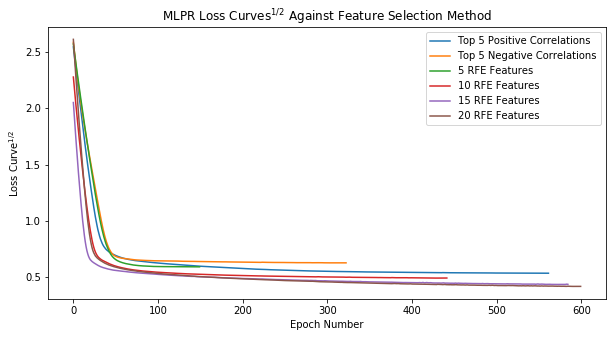

Feature Selection,MSE on Training Set,MSE on Test Set,R$^2$ Score
5 Top Positive Correlations,0.567213,0.516709,0.384288
5 Top Negative Correlations,0.781126,0.714312,0.148824
5 RFE Features,0.694919,0.679419,0.190402
10 RFE Features,0.478423,0.515378,0.385874
15 RFE Features,0.372683,0.456089,0.456523
20 RFE Features,0.344308,0.599769,0.285314


In [10]:
plt.figure(figsize=(10,5))

plt.plot(np.sqrt(MLPRTop5p.loss_curve_),label='Top 5 Positive Correlations')
plt.plot(np.sqrt(MLPRTop5n.loss_curve_),label='Top 5 Negative Correlations')
plt.plot(np.sqrt(MLPR5.loss_curve_),label='5 RFE Features')
plt.plot(np.sqrt(MLPR10.loss_curve_),label='10 RFE Features')
plt.plot(np.sqrt(MLPR15.loss_curve_),label='15 RFE Features')
plt.plot(np.sqrt(MLPR20.loss_curve_),label='20 RFE Features')

plt.title('MLPR Loss Curves$^{1/2}$ Against Feature Selection Method')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Curve$^{1/2}$')
plt.legend(loc='best')
plt.show()

MLPRTop5p_train_pred = MLPRTop5p.predict(X_train1)
MLPRTop5n_train_pred = MLPRTop5n.predict(X_train2)
MLPR5_train_pred = MLPR5.predict(X_train3)
MLPR10_train_pred = MLPR10.predict(X_train4)
MLPR15_train_pred = MLPR15.predict(X_train5)
MLPR20_train_pred = MLPR20.predict(X_train6)

MLPRTop5p_test_pred = MLPRTop5p.predict(X_test1)
MLPRTop5n_test_pred = MLPRTop5n.predict(X_test2)
MLPR5_test_pred = MLPR5.predict(X_test3)
MLPR10_test_pred = MLPR10.predict(X_test4)
MLPR15_test_pred = MLPR15.predict(X_test5)
MLPR20_test_pred = MLPR20.predict(X_test6)

summarydata = [['5 Top Positive Correlations',mean_squared_error(y_train, MLPRTop5p_train_pred),
             mean_squared_error(y_test, MLPRTop5p_test_pred),MLPRTop5p_r2_score],
            ['5 Top Negative Correlations',mean_squared_error(y_train, MLPRTop5n_train_pred),
             mean_squared_error(y_test, MLPRTop5n_test_pred),MLPRTop5n_r2_score],
            ['5 RFE Features',mean_squared_error(y_train, MLPR5_train_pred),
             mean_squared_error(y_test, MLPR5_test_pred),MLPR5_r2_score],
            ['10 RFE Features',mean_squared_error(y_train, MLPR10_train_pred),
             mean_squared_error(y_test, MLPR10_test_pred),MLPR10_r2_score],
            ['15 RFE Features',mean_squared_error(y_train, MLPR15_train_pred),
             mean_squared_error(y_test, MLPR15_test_pred),MLPR15_r2_score],
            ['20 RFE Features',mean_squared_error(y_train, MLPR20_train_pred),
             mean_squared_error(y_test, MLPR20_test_pred),MLPR20_r2_score]]

df=pd.DataFrame(summarydata, columns=['Feature Selection','MSE on Training Set','MSE on Test Set','R$^2$ Score'])#.style.hide_index()
#df.style.apply(custom_style, axis=1)
color = (df['Feature Selection'] == '15 RFE Features').map({True: 'background-color: yellow', False: ''})
df.style.apply(lambda s: color).hide_index()

**Note:** Collapsing the four *OP_time* groups into two yields worse results overall; MLPR with 10 RFE features is the best model, performing slightly better than MLPR with 15 RFE features (MSE of 0.379857 and an R$^2$ score of 0.435969).